## Guess the Genre!
k-nn Classification on Spotify songs based on their numerical statistics.

## Introduction

provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report</br>
clearly state the question you tried to answer with your project</br>
identify and describe the dataset that was used to answer the question</br>

### Methods & Results

In [191]:
### Loading Libraries into R
### Run this cell before continuing.
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

**1. Loading the Data** </br>
The data, originally sourced from Kaggle, is loaded in from an online source.

In [134]:
raw_data <- read_csv("https://raw.githubusercontent.com/Lollipop-27/DCSI100-Project/main/data/music_genre.csv")

Parsed with column specification:
cols(
  instance_id = col_double(),
  artist_name = col_character(),
  track_name = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_character(),
  obtained_date = col_character(),
  valence = col_double(),
  music_genre = col_character()
)



**2. Wrangling & Cleaning the Data** </br>
The data has a few rows with missing N/A values. We remove them using na.omit(). The raw data set we selected has about 50,000 rows, whose excessive size is a serious limitation on performance and causes minute-long load times. For sake of reasonable computation time and after discussion with the teaching assistant, we chose use group_by() and sample_n() to randomly select 1000 rows from each of the 10 genres, for a total of 10,000 rows.

In [186]:
set.seed(1234)

clean_data <- raw_data %>%
            na.omit() %>%
            group_by(music_genre) %>%
            sample_n(1000)

Some columns are unusable for predicting genre because kknn classification requires numerical predictors. We used select() to remove all character columns excluding the music_genre column, which we used mutate() to turn into factors.

A usable column with numerical values, tempo, is incorrectly stored as a character column. We use mutate() to turn it into a double. Of the remaining columns, instance_id, key, and obtained_date are identification are numerical, but do not contribute to predicting the genre. We used select() to remove these 3 columns.

In [187]:
# Removing the columns we don't need
selected_data <- clean_data %>%
                mutate(mode = as.factor(mode), music_genre = as.factor(music_genre)) %>%
                select(-instance_id, -key,-obtained_date, -artist_name, -track_name)

selected_data

popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<fct>
46,0.00468,0.496,228627,0.675,1.16e-05,0.114,-6.155,Major,0.0280,153.988,0.493,Alternative
42,0.00953,0.557,143525,0.931,0.00e+00,0.319,-3.499,Minor,0.2820,137.976,0.616,Alternative
44,0.01290,0.480,241200,0.923,6.28e-05,0.117,-4.062,Major,0.0382,134.304,0.434,Alternative
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,0.00746,0.530,226867,0.972,1.19e-03,0.356,-2.826,Minor,0.1090,136.001,0.5180,Rock
62,0.01280,0.214,175778,0.148,5.80e-02,0.113,-17.775,Major,0.0370,46.591,0.0277,Rock
61,0.82100,0.642,148867,0.462,2.55e-06,0.106,-8.026,Major,0.0294,130.018,0.4840,Rock


We now split the data into our training and testing sets.

In [188]:
data_split <- initial_split(selected_data, prop = 0.75, strata = music_genre) 
data_train <- training(data_split)
data_test <- testing(data_split)

**3. Exploratory Analysis (@Angela this is the part Im not sure about)** </br>

In [138]:
# ### Table for each Genre
# Electronic <- data_train %>%
#                 filter(music_genre == "Electronic") %>%
#                 group_by(music_genre) %>%
#                 summarize(Electronic_popularity = mean(popularity, na.ra = True),
#                          Electronic_acousticness = mean(acousticness, na.ra = True),
#                          Electronic_danceability = mean(danceability, na.ra = True),
#                          Electronic_duration_ms = mean(duration_ms, na.ra = True),
#                          Electronic_energy = mean(energy, na.ra = True),
#                          Electronic_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Electronic_liveness = mean(liveness, na.ra = True),
#                          Electronic_loudness = mean(loudness, na.ra = True),
#                          Electronic_speechiness = mean(speechiness, na.ra = True),
#                          Electronic_tempo = mean(tempo, na.ra = True),
#                          Electronic_valence = mean(valence, na.ra = True))
# Electronic

# Anime <- data_train %>%
#                 filter(music_genre == "Anime") %>%
#                 group_by(music_genre) %>%
#                 summarize(Anime_popularity = mean(popularity, na.ra = True),
#                          Anime_acousticness = mean(acousticness, na.ra = True),
#                          Anime_danceability = mean(danceability, na.ra = True),
#                          Anime_duration_ms = mean(duration_ms, na.ra = True),
#                          Anime_energy = mean(energy, na.ra = True),
#                          Anime_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Anime_liveness = mean(liveness, na.ra = True),
#                          Anime_loudness = mean(loudness, na.ra = True),
#                          Anime_speechiness = mean(speechiness, na.ra = True),
#                          Anime_tempo = mean(tempo, na.ra = True),
#                          Anime_valence = mean(valence, na.ra = True))
# Anime

# Jazz <- data_train %>%
#                 filter(music_genre == "Jazz") %>%
#                 group_by(music_genre) %>%
#                 summarize(Jazz_popularity = mean(popularity, na.ra = True),
#                          Jazz_acousticness = mean(acousticness, na.ra = True),
#                          Jazz_danceability = mean(danceability, na.ra = True),
#                          Jazz_duration_ms = mean(duration_ms, na.ra = True),
#                          Jazz_energy = mean(energy, na.ra = True),
#                          Jazz_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Jazz_liveness = mean(liveness, na.ra = True),
#                          Jazz_loudness = mean(loudness, na.ra = True),
#                          Jazz_speechiness = mean(speechiness, na.ra = True),
#                          Jazz_tempo = mean(tempo, na.ra = True),
#                          Jazz_valence = mean(valence, na.ra = True))
# Jazz

# Alternative <- data_train %>%
#                 filter(music_genre == "Alternative") %>%
#                 group_by(music_genre) %>%
#                 summarize(Alternative_popularity = mean(popularity, na.ra = True),
#                          Alternative_acousticness = mean(acousticness, na.ra = True),
#                          Alternative_danceability = mean(danceability, na.ra = True),
#                          Alternative_duration_ms = mean(duration_ms, na.ra = True),
#                          Alternative_energy = mean(energy, na.ra = True),
#                          Alternative_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Alternative_liveness = mean(liveness, na.ra = True),
#                          Alternative_loudness = mean(loudness, na.ra = True),
#                          Alternative_speechiness = mean(speechiness, na.ra = True),
#                          Alternative_tempo = mean(tempo, na.ra = True),
#                          Alternative_valence = mean(valence, na.ra = True))
# Alternative

# Country <- data_train %>%
#                 filter(music_genre == "Country") %>%
#                 group_by(music_genre) %>%
#                 summarize(Country_popularity = mean(popularity, na.ra = True),
#                          Country_acousticness = mean(acousticness, na.ra = True),
#                          Country_danceability = mean(danceability, na.ra = True),
#                          Country_duration_ms = mean(duration_ms, na.ra = True),
#                          Country_energy = mean(energy, na.ra = True),
#                          Country_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Country_liveness = mean(liveness, na.ra = True),
#                          Country_loudness = mean(loudness, na.ra = True),
#                          Country_speechiness = mean(speechiness, na.ra = True),
#                          Country_tempo = mean(tempo, na.ra = True),
#                          Country_valence = mean(valence, na.ra = True))
# Country

# Rap <- data_train %>%
#                 filter(music_genre == "Rap") %>%
#                 group_by(music_genre) %>%
#                 summarize(Rap_popularity = mean(popularity, na.ra = True),
#                          Rap_acousticness = mean(acousticness, na.ra = True),
#                          Rap_danceability = mean(danceability, na.ra = True),
#                          Rap_duration_ms = mean(duration_ms, na.ra = True),
#                          Rap_energy = mean(energy, na.ra = True),
#                          Rap_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Rap_liveness = mean(liveness, na.ra = True),
#                          Rap_loudness = mean(loudness, na.ra = True),
#                          Rap_speechiness = mean(speechiness, na.ra = True),
#                          Rap_tempo = mean(tempo, na.ra = True),
#                          Rap_valence = mean(valence, na.ra = True))
# Rap

# Blues <- data_train %>%
#                 filter(music_genre == "Blues") %>%
#                 group_by(music_genre) %>%
#                 summarize(Blues_popularity = mean(popularity, na.ra = True),
#                          Blues_acousticness = mean(acousticness, na.ra = True),
#                          Blues_danceability = mean(danceability, na.ra = True),
#                          Blues_duration_ms = mean(duration_ms, na.ra = True),
#                          Blues_energy = mean(energy, na.ra = True),
#                          Blues_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Blues_liveness = mean(liveness, na.ra = True),
#                          Blues_loudness = mean(loudness, na.ra = True),
#                          Blues_speechiness = mean(speechiness, na.ra = True),
#                          Blues_tempo = mean(tempo, na.ra = True),
#                          Blues_valence = mean(valence, na.ra = True))
# Blues

# Rock <- data_train %>%
#                 filter(music_genre == "Rock") %>%
#                 group_by(music_genre) %>%
#                 summarize(Rock_popularity = mean(popularity, na.ra = True),
#                          Rock_acousticness = mean(acousticness, na.ra = True),
#                          Rock_danceability = mean(danceability, na.ra = True),
#                          Rock_duration_ms = mean(duration_ms, na.ra = True),
#                          Rock_energy = mean(energy, na.ra = True),
#                          Rock_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Rock_liveness = mean(liveness, na.ra = True),
#                          Rock_loudness = mean(loudness, na.ra = True),
#                          Rock_speechiness = mean(speechiness, na.ra = True),
#                          Rock_tempo = mean(tempo, na.ra = True),
#                          Rock_valence = mean(valence, na.ra = True))
# Rock

# Classical <- data_train %>%
#                 filter(music_genre == "Classical") %>%
#                 group_by(music_genre) %>%
#                 summarize(Classical_popularity = mean(popularity, na.ra = True),
#                          Classical_acousticness = mean(acousticness, na.ra = True),
#                          Classical_danceability = mean(danceability, na.ra = True),
#                          Classical_duration_ms = mean(duration_ms, na.ra = True),
#                          Classical_energy = mean(energy, na.ra = True),
#                          Classical_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Classical_liveness = mean(liveness, na.ra = True),
#                          Classical_loudness = mean(loudness, na.ra = True),
#                          Classical_speechiness = mean(speechiness, na.ra = True),
#                          Classical_tempo = mean(tempo, na.ra = True),
#                          Classical_valence = mean(valence, na.ra = True))
# Classical

# Hip_Hop <- data_train %>%
#                 filter(music_genre == "Hip-Hop") %>%
#                 group_by(music_genre) %>%
#                 summarize(Hip_Hop_popularity = mean(popularity, na.ra = True),
#                          Hip_Hop_acousticness = mean(acousticness, na.ra = True),
#                          Hip_Hop_danceability = mean(danceability, na.ra = True),
#                          Hip_Hop_duration_ms = mean(duration_ms, na.ra = True),
#                          Hip_Hop_energy = mean(energy, na.ra = True),
#                          Hip_Hop_instrumentalness = mean(instrumentalness, na.ra = True),
#                          Hip_Hop_liveness = mean(liveness, na.ra = True),
#                          Hip_Hop_loudness = mean(loudness, na.ra = True),
#                          Hip_Hop_speechiness = mean(speechiness, na.ra = True),
#                          Hip_Hop_tempo = mean(tempo, na.ra = True),
#                          Hip_Hop_valence = mean(valence, na.ra = True))
# Hip_Hop

In [139]:
# # proportion of music genre by mode(major, minor)
# mode_proportion_plot <- data_train %>%
# ggplot(aes(x = mode, fill = music_genre))+
# geom_bar(position = "fill")+
# labs(x = "Mode", y = "Proportion of music genre", fill = "music genre") +
# ggtitle("Proportion of music genre by mode(major, minor)")
# mode_proportion_plot

We visualize the proportion of musical genres by mode or major and minor. Mainly because we wanted to know whether the proportion of major or minor will be higher in a particular genre of music. We found that no music type has a higher proportion, and all music is well balanced. There is much more classical music in major than in minor, which was kind of shocking.

**4. Data Analysis** </br>
For the data recipe, we choose to use popularity, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, and valence as our predictors to predict the music genre.

We perform five-fold cross validation on our data with the data_recipe and data_spec we created earlier and try 20 different k values. We used collect_metrics() to aggregate the mean and standard error for each k value, and plot it on a line plot to visualize the accuracies and identify the best neighbour count.

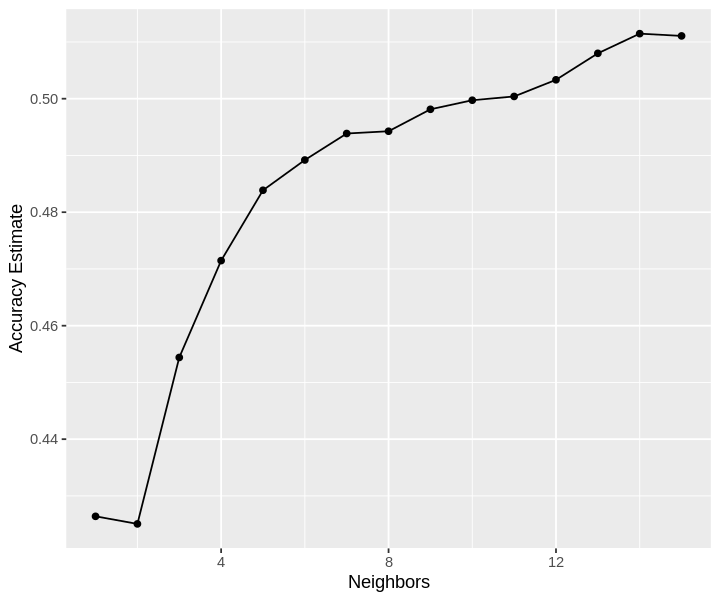

In [140]:
# Set the seed
set.seed(1234) 

# Create the model
genre_recipe <- recipe(music_genre ~ popularity + acousticness + danceability + duration_ms + energy + instrumentalness + liveness + loudness + speechiness + valence,
                      data = data_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

genre_vfold <- vfold_cv(data_train, v = 5, strata = music_genre)

genre_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

genre_results <- workflow() %>%
      add_recipe(genre_recipe) %>%
      add_model(genre_tune) %>%
      tune_grid(resamples = genre_vfold, grid = 20) %>%
      collect_metrics()

accuracies <- genre_results %>%
      filter(.metric == "accuracy")

# Display the k value accuracies
options(repr.plot.height = 5, repr.plot.width = 6)

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot

Accuracy is highest at k=14, so we recreate our workflow using k=14.

In [192]:
# Set the seed. 
set.seed(9999) 

# Build model with k=14
genre_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
       set_engine("kknn") %>%
       set_mode("classification")

genre_fit <- workflow() %>%
       add_recipe(data_recipe) %>%
       add_model(genre_spec) %>%
       fit(data = data_train)

We used our final model to make predictions on the test data set, and used the bind_cols function to join the prediction column to the original test data. We then report the accuracy of this prediction using the metrics function. We also report the confusion matrix using the conf_mat function.

In [193]:
data_predictions <- predict(genre_fit , data_test) %>%
      bind_cols(data_test)

data_metrics <- data_predictions %>%
       metrics(truth = music_genre, estimate = .pred_class)

data_conf_mat<- data_predictions %>%
       conf_mat(truth = music_genre, estimate = .pred_class)

data_metrics
data_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5188000
kap,multiclass,0.4653333


             Truth
Prediction    Alternative Anime Blues Classical Country Electronic Hip-Hop Jazz
  Alternative          81     7    15         6      29         17       5   10
  Anime                 3   162    33         9       4         13       0    6
  Blues                 4    17   106         7      19         12       0   19
  Classical             0    22     5       197       1          5       0   25
  Country              46    15    46         5     132         18       6   32
  Electronic            6    17    12         7       4        143       3   26
  Hip-Hop              23     0     1         0       6          9     110   12
  Jazz                 12     8    23        17       8         18       1  104
  Rap                  25     0     2         0      12          7     103    7
  Rock                 50     2     7         2      35          8      22    9
             Truth
Prediction    Rap Rock
  Alternative  18   28
  Anime         0    0
  Blues      

It seems Anime, Blues, Classical, Country, and Rock are predicted with good accuracy, but Alternative, Electronic, Hip-Hop, Jazz and Rap are easily confused with one or a few other genres (Understandably, hip-hop and rap, for example, are very similar genres and have a lot of overlap).

**5. Let's Try it Out!** </br>
The numerical data of three songs is used to predict each of their classifications. Let's try them out and see what we get.

In [194]:
# Symphony No. 5 in C minor, Ludwig van Beethoven
new_obs_1 <- tibble(popularity = 33,
                    acousticness = 0.927,
                    danceability = 0.351,
                    duration_ms = 282067,
                    energy = 0.0964,
                    instrumentalness = 0.899,
                    liveness = 0.509,
                    loudness = -20.044,
                    speechiness = 0.0436,
                    valence = 0.246)

class_prediction_1 <-  predict(genre_fit, new_obs_1)
class_prediction_1 %>% pull(.pred_class)

[1] Classical
10 Levels: Alternative Anime Blues Classical Country Electronic ... Rock

In [195]:
# Call Your Name, Hiroyuki Sawano
new_obs_2 <- tibble(popularity = 50,
                    acousticness = 0.0145,
                    danceability = 0.567,
                    duration_ms = 268333,
                    energy = 0.3,
                    instrumentalness = 0,
                    liveness = 0.0687,
                    loudness = -8.421,
                    speechiness = 0.0291,
                    valence = 0.196)

class_prediction_2 <-  predict(genre_fit, new_obs_2)
class_prediction_2 %>% pull(.pred_class)

[1] Rock
10 Levels: Alternative Anime Blues Classical Country Electronic ... Rock

In [196]:
# She Ain't You, Chris Brown
new_obs_3 <- tibble(popularity = 51,
                    acousticness = 0.0341,
                    danceability = 0.634,
                    duration_ms = 248107,
                    energy = 0.716,
                    instrumentalness = 0,
                    liveness = 0.0877,
                    loudness = -6.502,
                    speechiness = 0.128,
                    valence = 0.619)
class_prediction_3 <-  predict(genre_fit, new_obs_3)

class_prediction_3 %>% pull(.pred_class)

[1] Alternative
10 Levels: Alternative Anime Blues Classical Country Electronic ... Rock

If you've listened to these songs before, you'll know the prediction is generally correct. It seems our model works!

### Discussion

<ul>
    <li>summarize what you found</li>
    <li>discuss whether this is what you expected to find?</li>
    <li>discuss what impact could such findings have?</li>
    <li>discuss what future questions could this lead to?</li>
</ul>

## References

Lena, J. C., & Peterson, R. A. (2008). Classification as Culture: Types and Trajectories of 

    Music Genres. American Sociological Review, 73(5), 697–718. 
    
    https://doi.org/10.1177/000312240807300501
    
Sturm, B. L. (2013). Classification accuracy is not enough. Journal of Intelligent Information 

    Systems, 41(3), 371–406. 
    
    https://doi.org/10.1007/s10844-013-0250-y
    
How do new music genres emerge? Diversification processes in symbolic knowledge bases. 

    (2019). Retrieved March 11, 2022, from Regional Studies website: 
    
    https://www.tandfonline.com/doi/full/10.1080/00343404.2019.1580817
    
Innovation in Creative Industries: Does (Related) Variety Matter for the Creativity of Urban 

    Music Scenes? (2019). Retrieved March 11, 2022, from Economic Geography website: https://www.tandfonline.com/doi/full/10.1080/00130095.2018.1549944?src=recsys